* IDR optimal peak set: 129442 peaks "/srv/scratch/annashch/dmso/raw_data/"
* input: fc signal strength for the pooled pseudo replicates over the IDR peaks 

In [14]:
rm(list=ls())
library(limma)
library(sva)
library(ggplot2)

In [15]:
data=data.frame(read.table('/srv/scratch/annashch/dmso/atacseq_merged.txt',header=TRUE,sep='\t'))
chrom=data$Chrom
start_pos=data$Start
end_pos=data$End
unique_names=paste(chrom,start_pos,end_pos,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL
rownames(data)=unique_names


In [16]:
batches=data.frame(read.table('/srv/scratch/annashch/dmso/atacseq_batches.txt',header=TRUE,sep='\t'))
#pc1 is weird -- no correspondence to DMSO vs Control or Timepoint , need to perform SVA
mod1=model.matrix(~0+Treatment+Timepoint,data=batches)
mod0=model.matrix(~1,data=batches)
v=voom(counts=data,design=mod1)

In [17]:
batches


Rep,Sample,Treatment,Timepoint
atac_earlyG1_ld_control_pr1,atac_earlyG1_ld_control,control,earlyG1
atac_earlyG1_ld_control_pr2,atac_earlyG1_ld_control,control,earlyG1
atac_earlyG1_ld_treated_pr1,atac_earlyG1_ld_treated,treated,earlyG1
atac_earlyG1_ld_treated_pr2,atac_earlyG1_ld_treated,treated,earlyG1
atac_lateG1_ld_control_pr1,atac_lateG1_ld_control,control,lateG1
atac_lateG1_ld_control_pr2,atac_lateG1_ld_control,control,lateG1
atac_lateG1_ld_treated_pr1,atac_lateG1_ld_treated,treated,lateG1
atac_lateG1_ld_treated_pr2,atac_lateG1_ld_treated,treated,lateG1
atac_SG2M_ld_control_pr1,atac_SG2M_ld_control,control,SG2M
atac_SG2M_ld_control_pr2,atac_SG2M_ld_control,control,SG2M


In [18]:
#sva 
sva.obj=sva(v$E,mod1,mod0)
colnames(sva.obj$sv)=c("sva1","sva2","sva3","sva4","sva5")
mod2=cbind(mod1,sva.obj$sv)
v=voom(counts=data,design=mod2)
fit <- lmFit(v, mod2)
sv_contribs=coefficients(fit)[,c(5,6,7,8,9)] %*% t(fit$design[,c(5,6,7,8,9)])


Number of significant surrogate variables is:  5 
Iteration (out of 5 ):1  2  3  4  5  

In [19]:
data_corrected=v$E-sv_contribs


[1] 2.427106e+01 1.977604e+01 1.707640e+01 1.315931e+01 1.278576e+01
 [6] 1.273175e+01 1.230485e-01 4.307899e-02 1.586404e-02 1.242878e-02
[11] 5.261893e-03 1.358809e-27

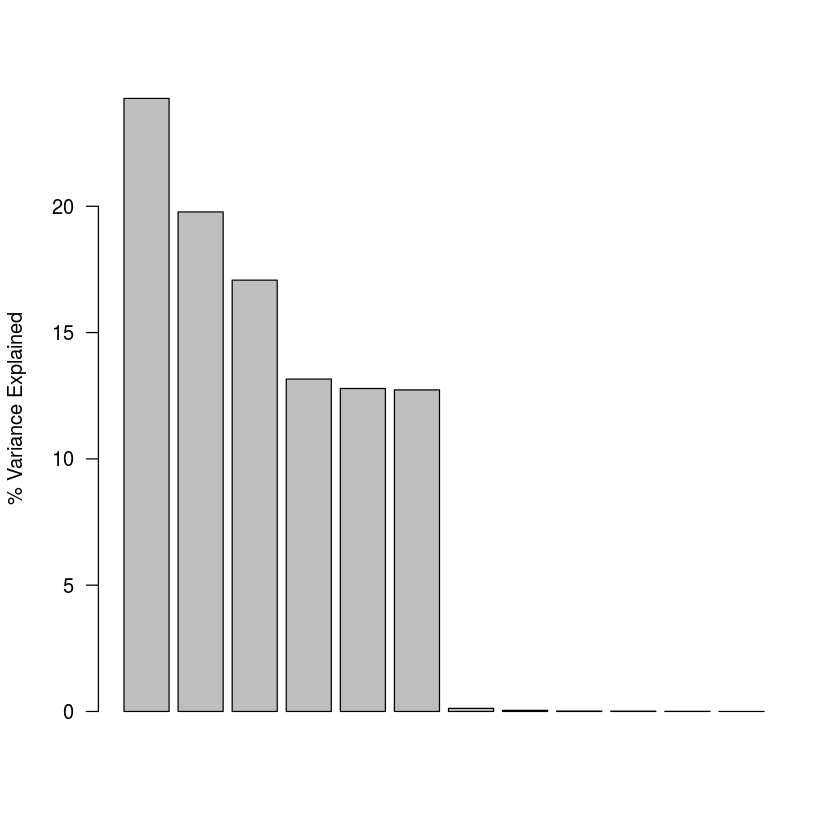

In [20]:
data.pca=prcomp(t(data_corrected))

barplot(100*data.pca$sdev^2/sum(data.pca$sdev^2),las=2,xlab="",ylab="% Variance Explained")
100*data.pca$sdev^2/sum(data.pca$sdev^2)

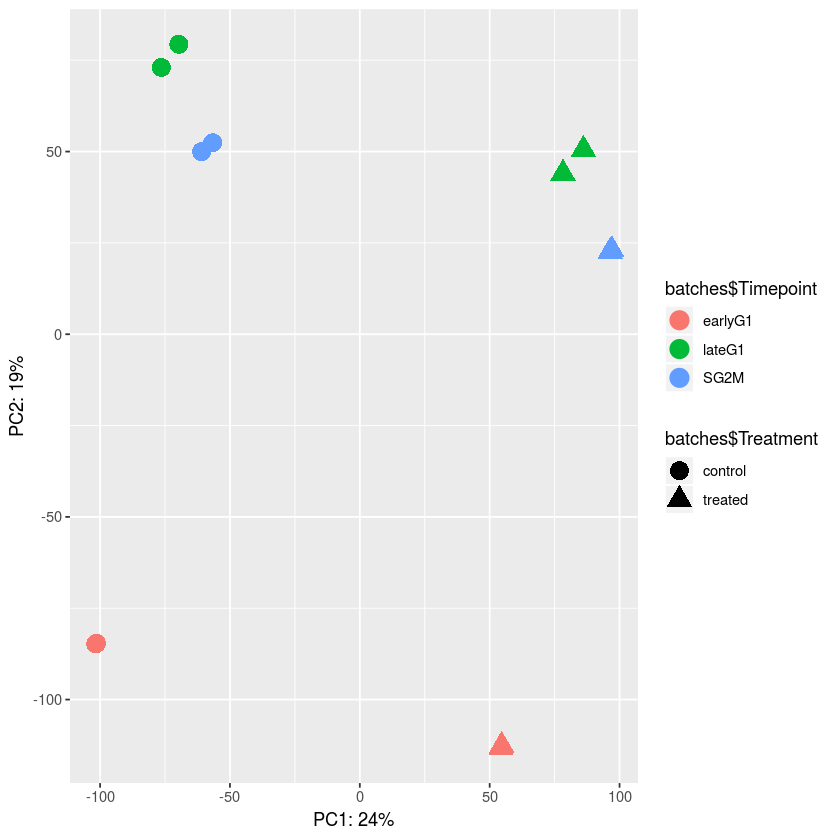

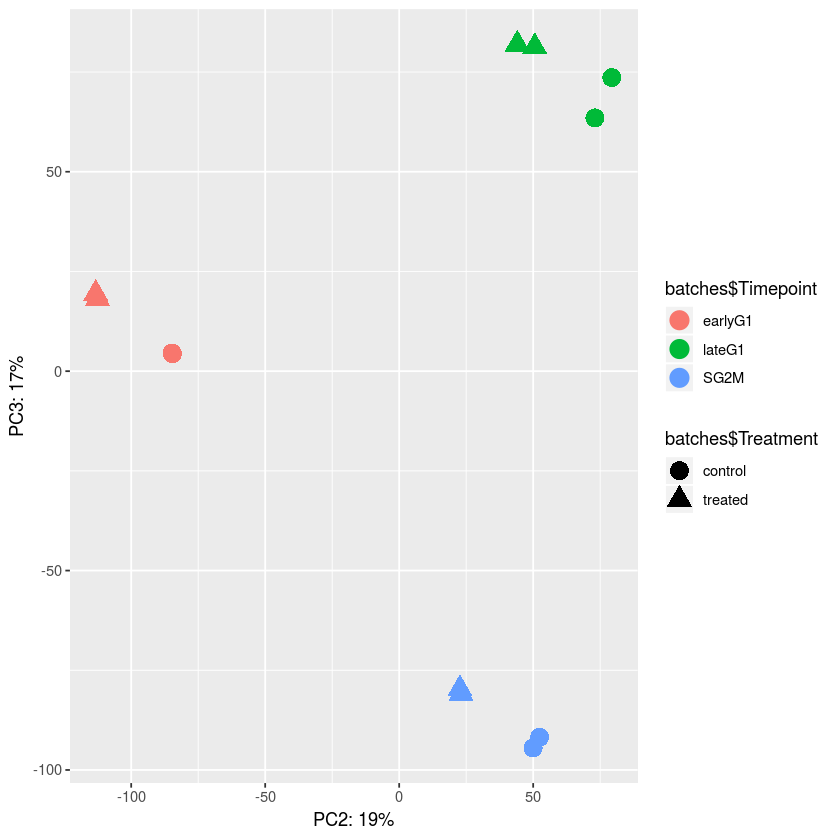

In [21]:
batches=cbind(batches,data.pca$x)

print(ggplot(data=batches,
             aes(x=batches$PC1,
                 y=batches$PC2,
                 label=batches$Rep,
                 shape=batches$Treatment,
                 color=batches$Timepoint))+
    geom_point(size=5)+
    xlab("PC1: 24%")+
    ylab("PC2: 19%"))

print(ggplot(data=batches,
             aes(x=batches$PC2,
                 y=batches$PC3,
                 label=batches$Rep,
                 shape=batches$Treatment,
                 color=batches$Timepoint))+
    geom_point(size=5)+
    xlab("PC2: 19%")+
    ylab("PC3: 17%"))


In [22]:
write.csv(data_corrected,"atac_corrected.csv")


In [29]:
#We re-run the linear fit on the corrected data 
mod3=model.matrix(~0+Sample,data=batches)
fit2 <- lmFit(data_corrected, mod3)
#specify the contrasts 
cont.matrix=makeContrasts(earlyg1_dmso_control="Sampleatac_earlyG1_ld_treated-Sampleatac_earlyG1_ld_control",
                          lateg1_dmso_control="Sampleatac_lateG1_ld_treated-Sampleatac_lateG1_ld_control",
                          sg2m_dmso_control="Sampleatac_SG2M_ld_treated-Sampleatac_SG2M_ld_control",
                          lateg1_earlyg1_dmso="Sampleatac_lateG1_ld_treated-Sampleatac_earlyG1_ld_treated",
                          sg2m_lateg1_dmso="Sampleatac_SG2M_ld_treated-Sampleatac_lateG1_ld_treated",
                          earlyg1_sg2m_dmso="Sampleatac_earlyG1_ld_treated-Sampleatac_SG2M_ld_treated",
                          lateg1_earlyg1_control="Sampleatac_lateG1_ld_control-Sampleatac_earlyG1_ld_control",
                          sg2m_lateg1_control="Sampleatac_SG2M_ld_control-Sampleatac_lateG1_ld_control",
                          earlyg1_sg2m_control="Sampleatac_earlyG1_ld_control-Sampleatac_SG2M_ld_control",
                          levels=mod3)
fit2=contrasts.fit(fit2,cont.matrix)
e=eBayes(fit2)
comparisons=colnames(cont.matrix)
gene_names=unique_names
for(i in seq(1,9))
{
  tab<-topTable(e, number=nrow(data),coef=i,lfc=1,p.value = 0.05)
  names(tab)[1]=comparisons[i]
  tab$Chrom_Start_End=rownames(tab)
  write.table(tab,file=paste("atac_differential_",comparisons[i],".tsv",sep=""),quote=FALSE,sep='\t',row.names = FALSE)
}

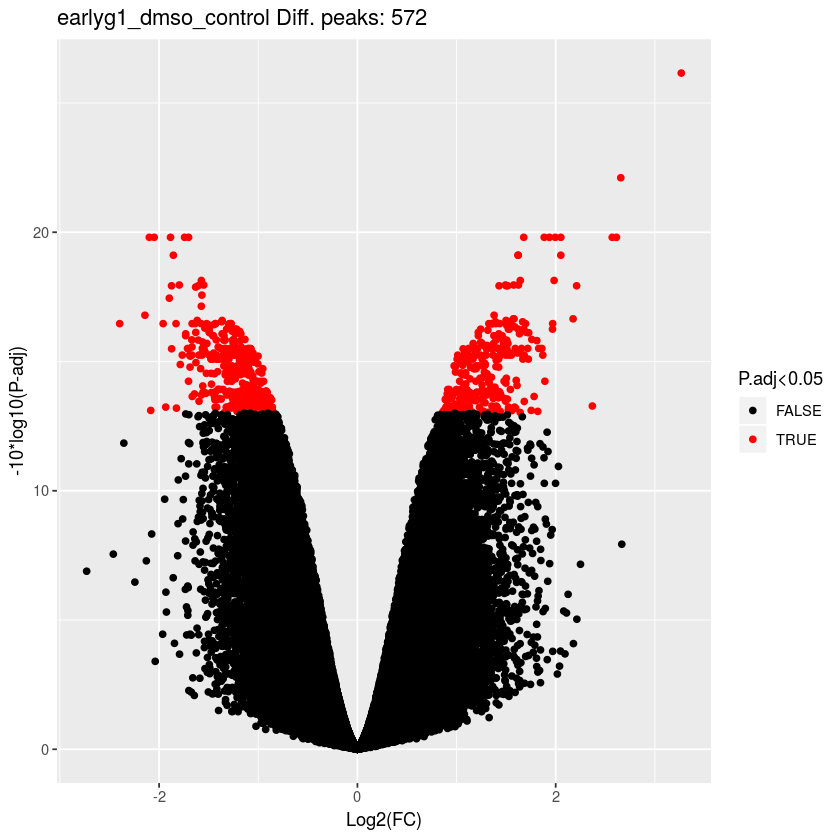

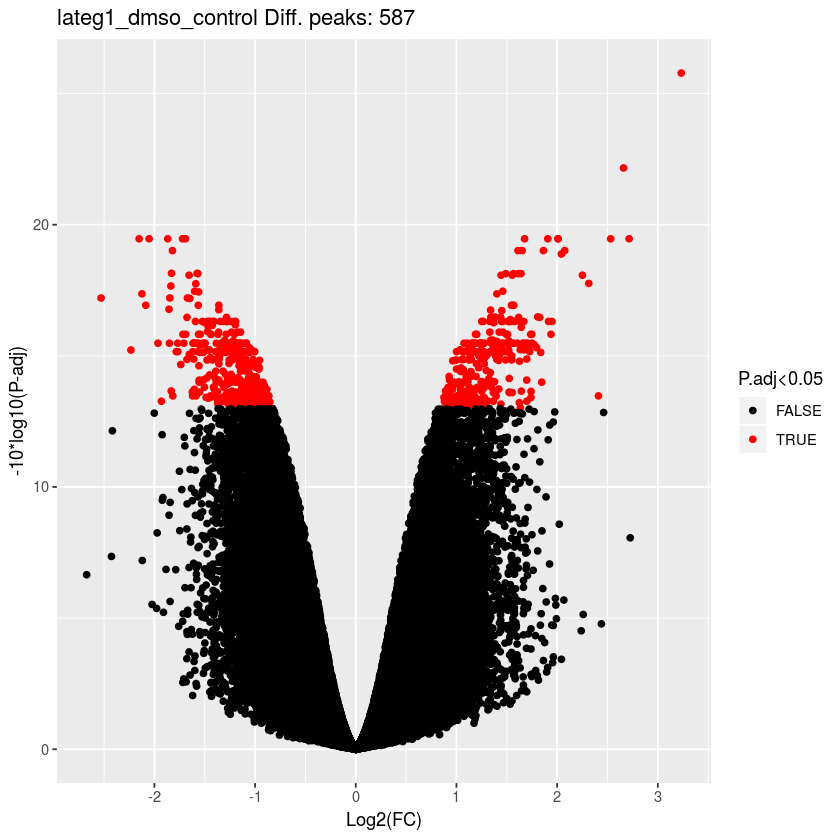

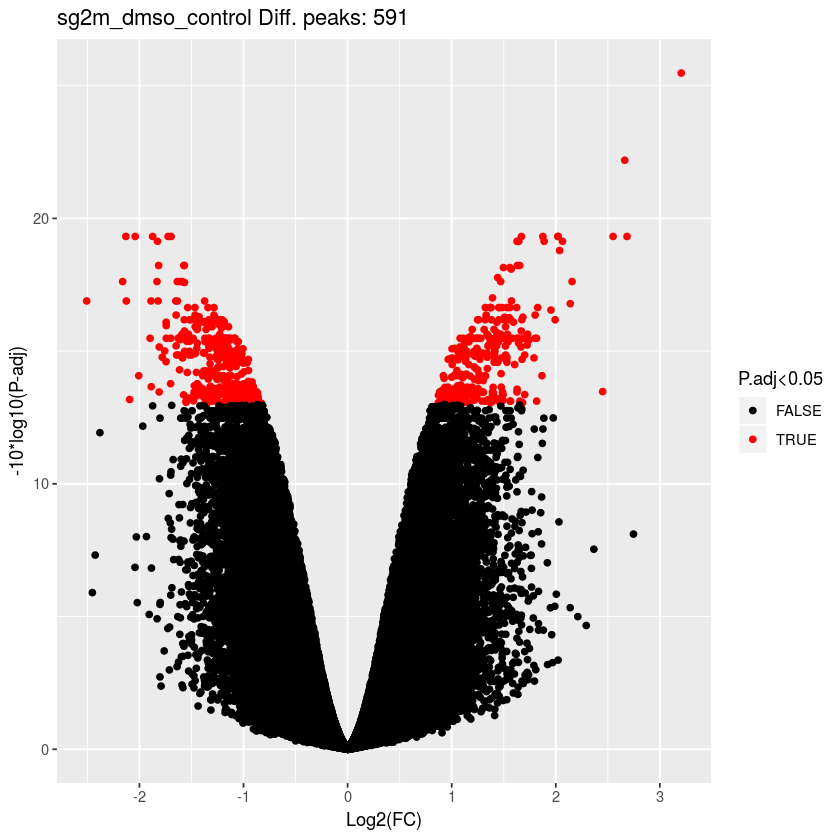

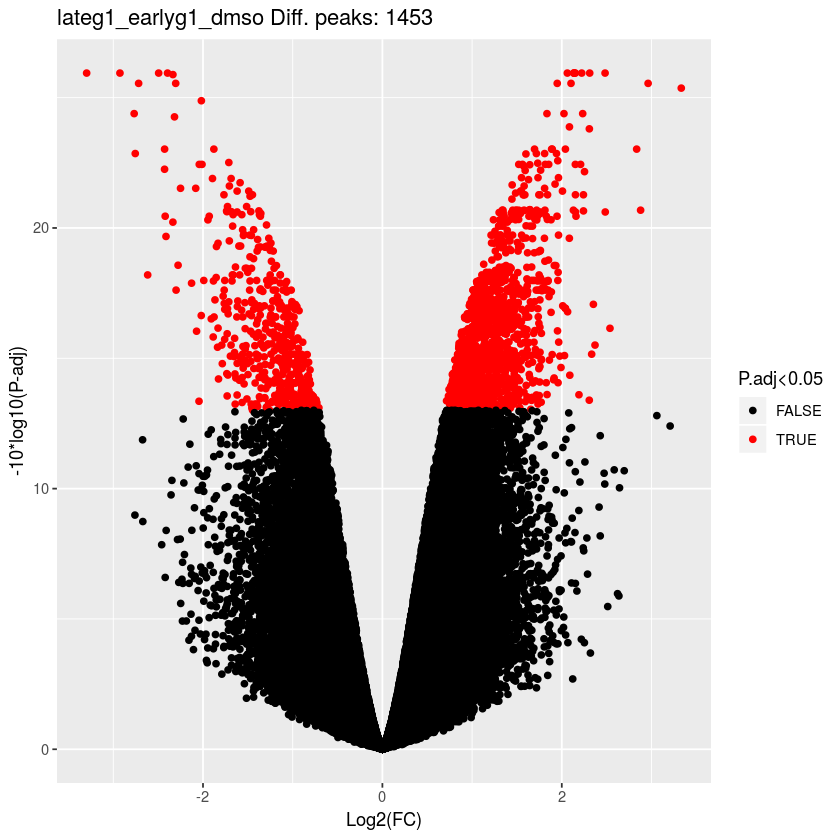

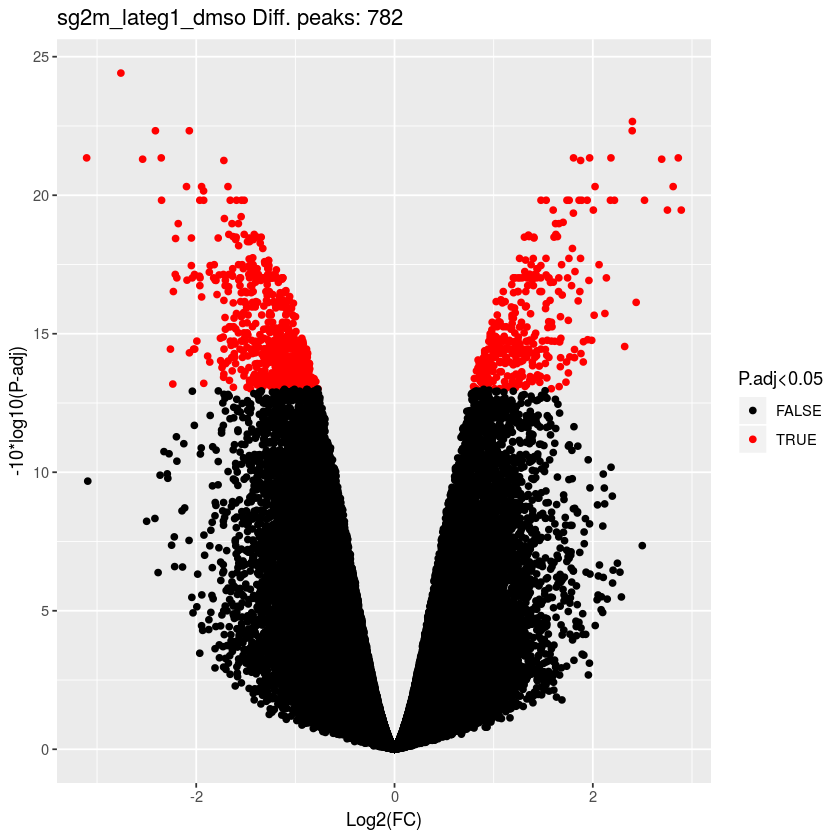

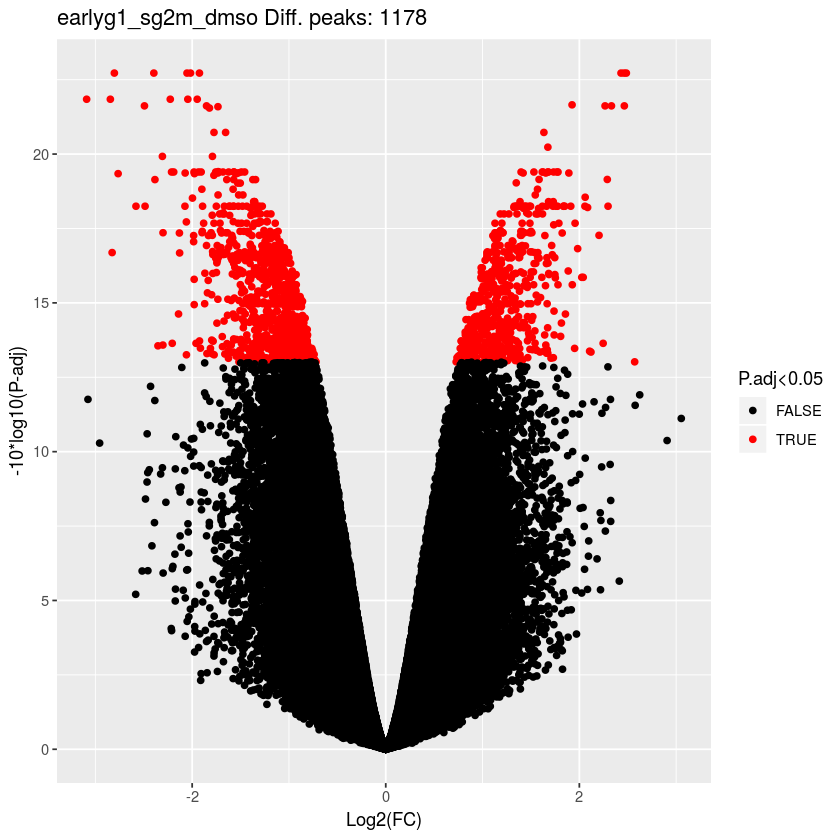

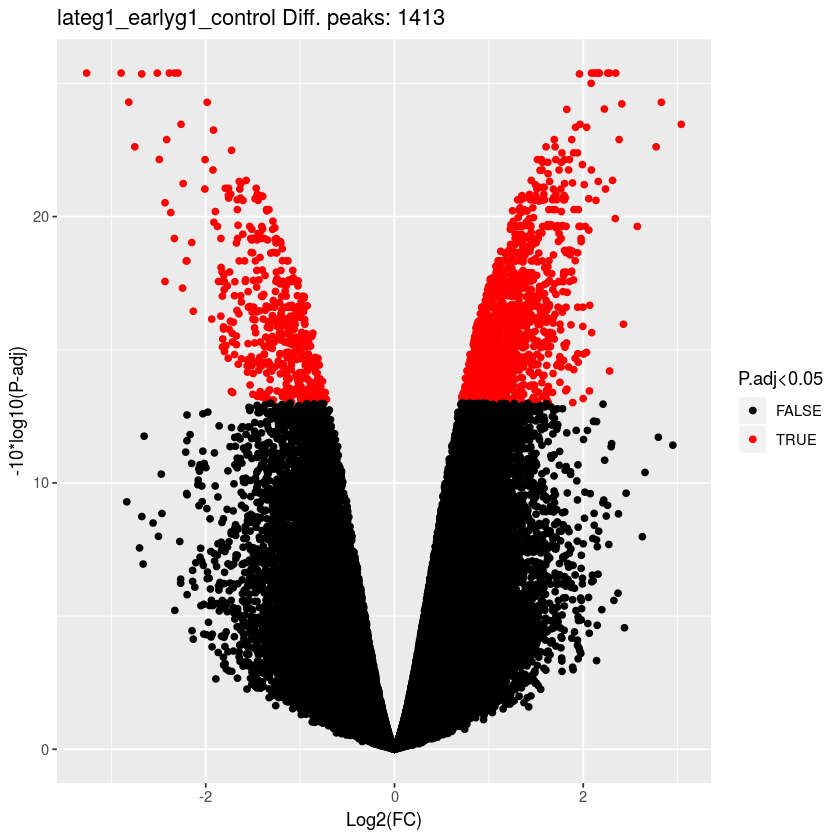

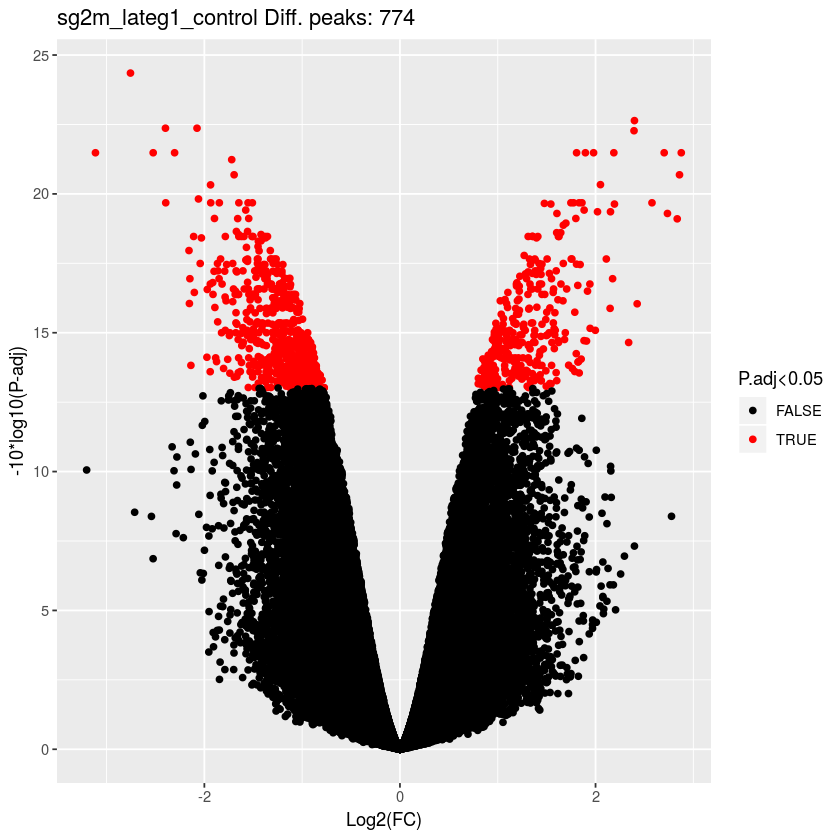

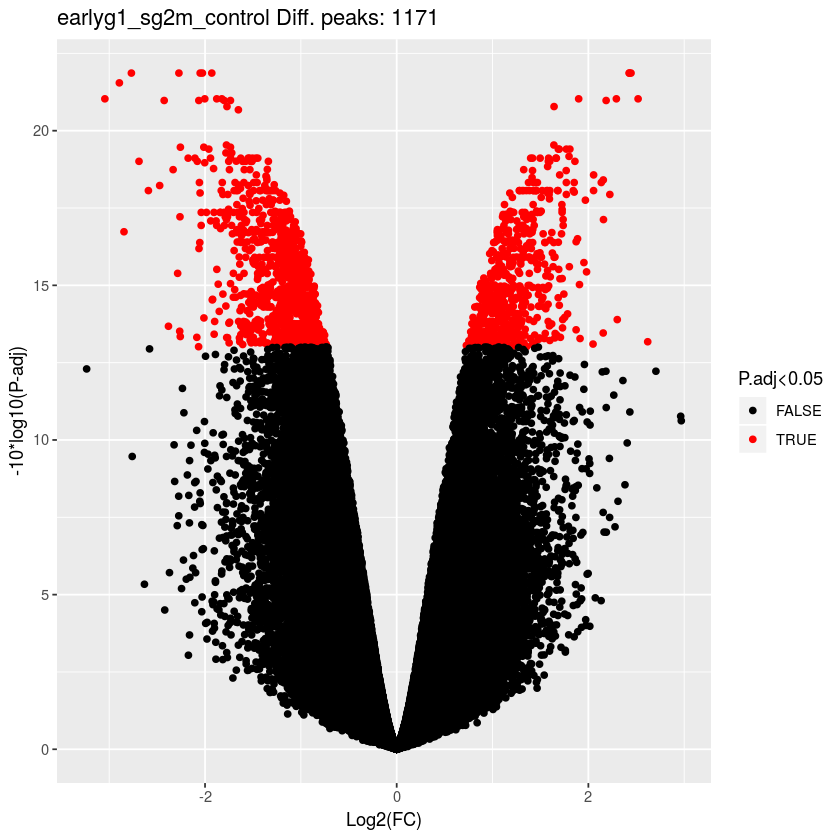

In [24]:
for(i in seq(1,length(comparisons)))
{
 res=as.data.frame(topTable(e, number=nrow(e),coef=i))
 res$logPadj=-10*log10(res$adj.P.Val)
 numsig=sum((abs(res$logFC)>1) & (res$adj.P.Val <= 0.05))
 sigsubset=res[res$adj.P.Val<=0.05,]
 outlabel=paste(comparisons[i],"Diff. peaks:",numsig)
 res$color=res$adj.P.Val<=0.05

 #png(outpng)#,width=5,height=5,pointsize=12)
 print(ggplot(data=res,
        aes(x=res$logFC,
            y=res$logPadj,
            color=res$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
}


In [26]:
system("ls",intern=TRUE)

[1] "atac_corrected.csv"                          
 [2] "ATAC.cpm.corrected"                          
 [3] "atac_differential_earlyg1_dmso_control.tsv"  
 [4] "atac_differential_earlyg1_sg2m_control.tsv"  
 [5] "atac_differential_earlyg1_sg2m_dmso.tsv"     
 [6] "atac_differential_lateg1_dmso_control.tsv"   
 [7] "atac_differential_lateg1_earlyg1_control.tsv"
 [8] "atac_differential_lateg1_earlyg1_dmso.tsv"   
 [9] "atac_differential_sg2m_dmso_control.tsv"     
[10] "atac_differential_sg2m_lateg1_control.tsv"   
[11] "atac_differential_sg2m_lateg1_dmso.tsv"      
[12] "earlyg1_dmso_control.tsv"                    
[13] "lateg1_dmso_control.tsv"                     
[14] "limma_atacseq.R"                             
[15] "Relaxed Peaks Limma Voom with SVA .ipynb"    
[16] "sg2m_dmso_control.tsv"

In [31]:
system("cat atac_differential_earlyg1_dmso_control.tsv atac_differential_lateg1_dmso_control.tsv atac_differential_sg2m_dmso_control.tsv | cut -f7 | sort | uniq | sed --expression 's/\\_/\\t/g' | grep -v Chrom | bedtools sort -i stdin > all.diffpeaks.bed",intern=TRUE)

character(0)

In [34]:
system("bedtools closest -d -a all.diffpeaks.bed -b /srv/scratch/annashch/dmso/peak_to_gene_dist/diff_genes.bed | sort |uniq > peaks.closest.bed",intern=TRUE)

character(0)

In [35]:
data=read.table("peaks.closest.bed",header=FALSE,sep='\t')
head(data)


V1,V2,V3,V4,V5,V6,V7,V8
chr10,103668250,103668789,chr10,103544200,103578696,MGEA5,89555
chr10,103668250,103668789,chr10,103565800,103578696,MGEA5,89555
chr10,103668250,103668789,chr10,103578563,103578696,MGEA5,89555
chr10,106265322,106265753,chr10,105995114,106027217,GSTO1,238106
chr10,106265322,106265753,chr10,106013952,106027217,GSTO1,238106
chr10,106265322,106265753,chr10,106014468,106027217,GSTO1,238106


In [36]:
data$V8[data$V8 < 1]=1
data$V8[data$V8< -1]=1000000

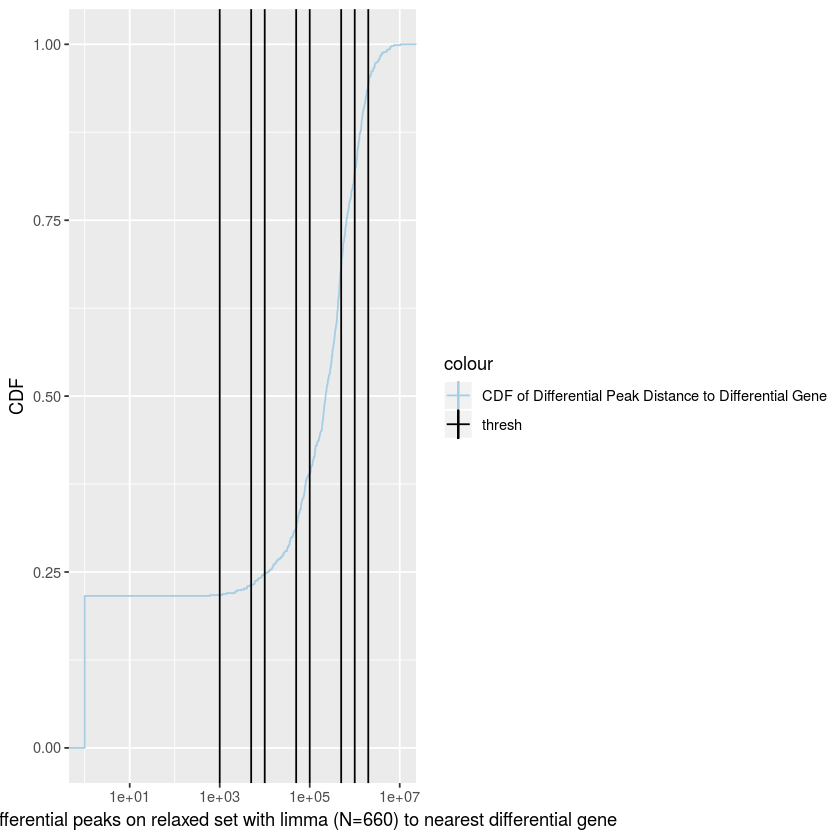

In [37]:
p1=ggplot()+
  stat_ecdf(data=data,aes(x=data$V8 ,color="CDF of Differential Peak Distance to Differential Gene"))+
  geom_vline(aes(xintercept=1000,color="thresh"))+
  geom_vline(aes(xintercept=5000,color="thresh"))+
  geom_vline(aes(xintercept=10000,color="thresh"))+
  geom_vline(aes(xintercept=50000,color="thresh"))+
  geom_vline(aes(xintercept=100000,color="thresh"))+
  geom_vline(aes(xintercept=500000,color="thresh"))+
  geom_vline(aes(xintercept=1000000,color="thresh"))+
  geom_vline(aes(xintercept=2000000,color="thresh"))+
  scale_x_continuous(trans='log10') +
  xlab("Distance from differential peaks on relaxed set with limma (N=660) to nearest differential gene")+
  ylab("CDF")+
scale_color_manual(values=c('#a6cee3','#000000'))

p1